In [3]:
import pandas as pd
import numpy as np
import dill

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn import model_selection, metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from sklearn.decomposition import PCA

#from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import BernoulliNB
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import IsolationForest

import itertools
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

## Opening en joining all the data that has been cleaned.

In [451]:
dataEvent = pd.read_csv('TrTeEvent.csv')
dataLog = pd.read_csv('TrTeLogF.csv')
dataSev = pd.read_csv('TrTeSev.csv')
dataRes = pd.read_csv('TrTeRe.csv')

In [452]:
dataEvent.head(2)

,id,location,fault_severity,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,...,event_type 2,event_type 42,Event_mode_0,Event_mode_2,event_type 30,event_type 45,event_type 10,event_type 32,event_type 13,location_count
0,1,601,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,24
1,2,474,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33


In [453]:
dataLog.head(2)

,id,feature 314,feature 293,feature 198,feature 303,feature 211,feature 309,feature 290,feature 233,feature 206,...,feature 172,feature 157,feature 71,feature 162,feature 134,feature 195,feature 230,feature 103,feature 307,feature_count
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5


In [454]:
dataSev.head(2)

,id,severity_type 1,severity_type 4,severity_type 5,severity_type 3,severity_type 2
0,1,1,0,0,0,0
1,2,0,0,0,0,1


In [455]:
dataRes.head(2)

,id,resource_type 6,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,1,1,0,0,1,0,0,0,0,0,0,2
1,2,0,1,0,0,0,0,0,0,0,0,1


In [456]:
data = dataEvent.merge(dataLog, how='left', on='id')
data = data.merge(dataSev, how='left', on='id')
data = data.merge(dataRes, how='left', on='id')
data.shape

(18552, 204)

In [457]:
data.head()

,id,location,fault_severity,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,1,601,1.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,2,474,NaN,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,3,64,NaN,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,645,NaN,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,460,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


data = data.sort(['location', 'id'])

dum = data[data['location'] == 1107]['id'].reset_index()

data[data['location'] == 1107].head(10).T

#np.array(dum['id'] - dum['id'].shift(1))[:10]

dum2 = list(data[data['fault_severity'] == 2].groupby('location')['fault_severity'].count())
print(dum2)

dum1 = list(data[data['fault_severity'] == 1].groupby('location')['fault_severity'].count())
print(dum1)

dum0 = list(data[data['fault_severity'] == 0].groupby('location')['fault_severity'].count())
print(dum0)

## Separating training and testing data

In [458]:
TrainingData = data.dropna()

In [459]:
TrainingData.head()

,id,location,fault_severity,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,1,601,1.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
4,5,460,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,6,332,1.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
7,8,243,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
12,13,418,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [460]:
TrainingData = TrainingData.reset_index().drop('index', 1)

In [461]:
TestingData = data[data.isnull().any(axis=1)]

In [462]:
TestingData = TestingData.drop('fault_severity', 1)
TestingData.head()

,id,location,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,event_type 21,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
1,2,474,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,3,64,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,645,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
6,7,638,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8,9,1100,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [463]:
TestingData = TestingData.reset_index().drop('index', 1)

In [464]:
TestingData.head()

,id,location,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,event_type 21,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,2,474,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,3,64,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,4,645,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,7,638,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,9,1100,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


TrainingData = TrainingData.reset_index().drop(['index', 'id', 
                                                'severity_type 3', 'severity_type 5'], 1)

In [465]:
TrainingData.head()

,id,location,fault_severity,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,1,601,1.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,5,460,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,6,332,1.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,8,243,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,13,418,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [466]:
TrainingData.columns[-10:]

Index(['resource_type 2', 'resource_type 1', 'resource_type 8',
       'resource_type 3', 'resource_type 5', 'resource_type 4',
       'resource_type 10', 'resource_type 9', 'resource_type 7',
       'resource_count'],
      dtype='object')

## Starting cross validation and model selection

In [467]:
X = TrainingData.drop(['fault_severity'], 1)
y = TrainingData['fault_severity']
#y0 = TrainingData['predict_0']
#y1 = TrainingData['predict_1']
#y2 = TrainingData['predict_2']

## XGBoost Classifier

In [468]:
class_names = [0,1,2]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [469]:
rcParams['figure.figsize'] = 15, 4

train = TrainingData
target = 'fault_severity'
IDcol = 'id'

In [488]:
d_vector = ''
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=5):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgb_param['num_training'] =7831
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='mlogloss', early_stopping_rounds=early_stopping_rounds,
                          callbacks=[xgb.callback.print_evaluation(show_stdv=False)])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['fault_severity'], eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['fault_severity'].values, 
                                                     dtrain_predictions))

    global d_vector
    d_vector = alg.booster().get_fscore()                
    feat_imp = pd.Series(d_vector).sort_values(axis=0, ascending=False)

    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(dtrain['fault_severity'].values, dtrain_predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()  
    print(alg)

[0]	train-mlogloss:1.03208	test-mlogloss:1.03846
[1]	train-mlogloss:0.96781	test-mlogloss:0.981567
[2]	train-mlogloss:0.909663	test-mlogloss:0.930502
[3]	train-mlogloss:0.855774	test-mlogloss:0.884402
[4]	train-mlogloss:0.809328	test-mlogloss:0.844209
[5]	train-mlogloss:0.767299	test-mlogloss:0.808454
[6]	train-mlogloss:0.730793	test-mlogloss:0.778244
[7]	train-mlogloss:0.698296	test-mlogloss:0.751608
[8]	train-mlogloss:0.667908	test-mlogloss:0.727133
[9]	train-mlogloss:0.640379	test-mlogloss:0.705667
[10]	train-mlogloss:0.615475	test-mlogloss:0.686354
[11]	train-mlogloss:0.593375	test-mlogloss:0.668928
[12]	train-mlogloss:0.573252	test-mlogloss:0.653811
[13]	train-mlogloss:0.555005	test-mlogloss:0.640364
[14]	train-mlogloss:0.537104	test-mlogloss:0.627801
[15]	train-mlogloss:0.521415	test-mlogloss:0.616389
[16]	train-mlogloss:0.507279	test-mlogloss:0.606492
[17]	train-mlogloss:0.493575	test-mlogloss:0.597521
[18]	train-mlogloss:0.481451	test-mlogloss:0.588919
[19]	train-mlogloss:0.470

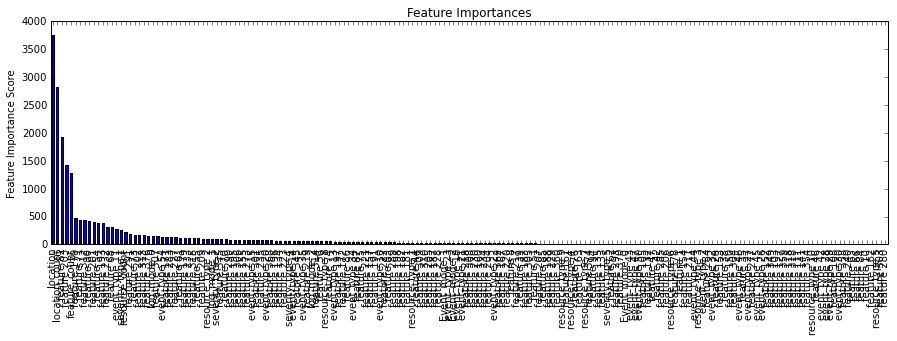

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


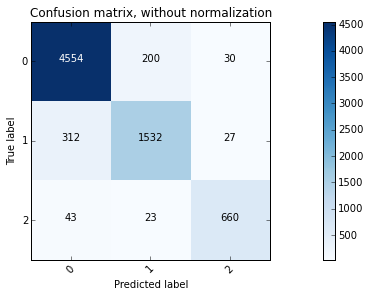

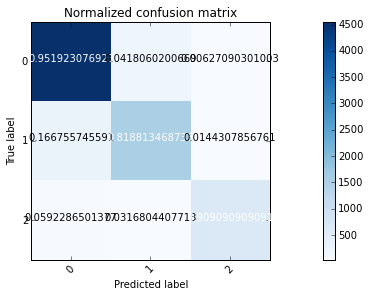

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=1, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=80, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)


In [489]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=10,
                     min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8, max_delta_step = 1,
                     objective= 'multi:softprob',nthread=4,scale_pos_weight=1,seed=27)
modelfit(xgb1, train, predictors)

## Lets now start tweaking parameters (max_depth and min_child_weight)

In [472]:
param_test1 = {'max_depth':range(6,19,2), 'min_child_weight':range(10,31,10)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140, max_delta_step=1,
                                                  max_depth=10,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'multi:softprob', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,
                        iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.50590, std: 0.00938, params: {'min_child_weight': 10, 'max_depth': 6},
  mean: -0.51540, std: 0.00977, params: {'min_child_weight': 20, 'max_depth': 6},
  mean: -0.52563, std: 0.00658, params: {'min_child_weight': 30, 'max_depth': 6},
  mean: -0.50214, std: 0.01180, params: {'min_child_weight': 10, 'max_depth': 8},
  mean: -0.51252, std: 0.00983, params: {'min_child_weight': 20, 'max_depth': 8},
  mean: -0.52182, std: 0.00845, params: {'min_child_weight': 30, 'max_depth': 8},
  mean: -0.50389, std: 0.01265, params: {'min_child_weight': 10, 'max_depth': 10},
  mean: -0.51281, std: 0.01208, params: {'min_child_weight': 20, 'max_depth': 10},
  mean: -0.52092, std: 0.00748, params: {'min_child_weight': 30, 'max_depth': 10},
  mean: -0.50499, std: 0.01395, params: {'min_child_weight': 10, 'max_depth': 12},
  mean: -0.51376, std: 0.01154, params: {'min_child_weight': 20, 'max_depth': 12},
  mean: -0.52063, std: 0.00891, params: {'min_child_weight': 30, 'max_depth': 12},
  mean: -0

scoring options  = 'accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc'

In [111]:
# Best parameters: {'max_depth': 7, 'min_child_weight': 1},mean =  -0.49202491184178526

In [473]:
param_test2 = {'max_depth':[7,8,9], 'min_child_weight':[1,9,10,11]}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, 
                                                  max_depth=5, max_delta_step = 1,
                                                  min_child_weight=2, gamma=0, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'multi:softprob', nthread=4, 
                                                  scale_pos_weight=1,seed=27), 
                        param_grid = param_test2, scoring='neg_log_loss',
                        n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.49129, std: 0.01187, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: -0.50354, std: 0.01076, params: {'min_child_weight': 9, 'max_depth': 7},
  mean: -0.50373, std: 0.01043, params: {'min_child_weight': 10, 'max_depth': 7},
  mean: -0.50552, std: 0.01014, params: {'min_child_weight': 11, 'max_depth': 7},
  mean: -0.49254, std: 0.01242, params: {'min_child_weight': 1, 'max_depth': 8},
  mean: -0.50198, std: 0.01145, params: {'min_child_weight': 9, 'max_depth': 8},
  mean: -0.50214, std: 0.01180, params: {'min_child_weight': 10, 'max_depth': 8},
  mean: -0.50563, std: 0.00885, params: {'min_child_weight': 11, 'max_depth': 8},
  mean: -0.49435, std: 0.01483, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: -0.50229, std: 0.01258, params: {'min_child_weight': 9, 'max_depth': 9},
  mean: -0.50405, std: 0.01235, params: {'min_child_weight': 10, 'max_depth': 9},
  mean: -0.50593, std: 0.00857, params: {'min_child_weight': 11, 'max_depth': 9}],
 {'max_depth': 7, 'mi

In [115]:
# Best parameters (still): {'max_depth': 7, 'min_child_weight': 1},mean =  -0.49202491184178526

param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=140, max_depth=7,
                                                   min_child_weight=2, gamma=0, 
                                                   subsample=0.8, colsample_bytree=0.8,
                                                   objective= 'multi:softprob', 
                                                   nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2b.fit(train[predictors],train[target])

modelfit(gsearch2b.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

## Lets work on gamma

In [474]:
param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, max_depth=7, 
                                                  max_delta_step=1,
                                                  min_child_weight=1, gamma=0, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'multi:softprob', nthread=4, 
                                                  scale_pos_weight=1,seed=27), 
                        param_grid = param_test3, 
                        scoring='neg_log_loss',
                        n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.49129, std: 0.01187, params: {'gamma': 0.0},
  mean: -0.49172, std: 0.01192, params: {'gamma': 0.1},
  mean: -0.49082, std: 0.01242, params: {'gamma': 0.2},
  mean: -0.49181, std: 0.01288, params: {'gamma': 0.3},
  mean: -0.49074, std: 0.01216, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 -0.49074126541950819)

In [139]:
# best parameter {'gamma': 0.4}

[0]	train-mlogloss:1.03663	test-mlogloss:1.04006
[1]	train-mlogloss:0.978543	test-mlogloss:0.985418
[2]	train-mlogloss:0.926421	test-mlogloss:0.93693
[3]	train-mlogloss:0.878445	test-mlogloss:0.893203
[4]	train-mlogloss:0.837302	test-mlogloss:0.855231
[5]	train-mlogloss:0.800409	test-mlogloss:0.82131
[6]	train-mlogloss:0.768651	test-mlogloss:0.792623
[7]	train-mlogloss:0.740051	test-mlogloss:0.767317
[8]	train-mlogloss:0.713362	test-mlogloss:0.743635
[9]	train-mlogloss:0.689388	test-mlogloss:0.722919
[10]	train-mlogloss:0.66764	test-mlogloss:0.704253
[11]	train-mlogloss:0.647482	test-mlogloss:0.686667
[12]	train-mlogloss:0.630227	test-mlogloss:0.671922
[13]	train-mlogloss:0.614109	test-mlogloss:0.658306
[14]	train-mlogloss:0.598786	test-mlogloss:0.646562
[15]	train-mlogloss:0.585429	test-mlogloss:0.635607
[16]	train-mlogloss:0.573048	test-mlogloss:0.625717
[17]	train-mlogloss:0.561383	test-mlogloss:0.61649
[18]	train-mlogloss:0.550831	test-mlogloss:0.608255
[19]	train-mlogloss:0.541481

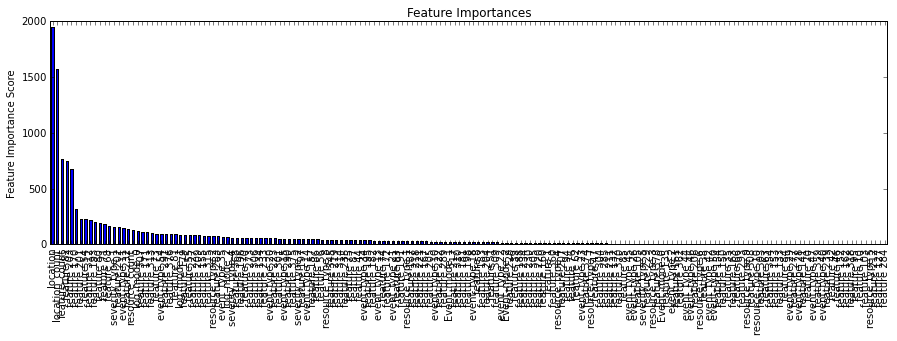

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


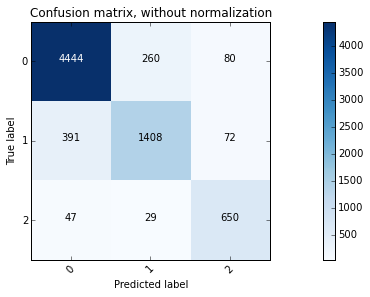

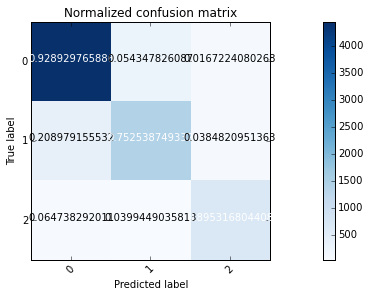

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.1, max_delta_step=1, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)


In [475]:
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=7, max_delta_step=1,
                     min_child_weight=1, gamma=0.4, subsample=0.8,
                     colsample_bytree=0.8, objective='multi:softprob', nthread=4,
                     scale_pos_weight=1, seed=27)
modelfit(xgb2, train, predictors)

## Lets work on subsample and colsample

In [476]:
param_test4 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140, max_depth=7,  
                                                  max_delta_step = 1,
                                                  min_child_weight=1, 
                                                  gamma=.4, subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'multi:softprob', 
                                                  nthread=4, scale_pos_weight=1,
                                                  seed=27), param_grid = param_test4, 
                        scoring='neg_log_loss',n_jobs=4,
                        iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.49328, std: 0.00965, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.49215, std: 0.01106, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.49150, std: 0.01172, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.49018, std: 0.01064, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.49294, std: 0.01020, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.49229, std: 0.01165, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.49189, std: 0.01133, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.49068, std: 0.01020, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.49300, std: 0.01154, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.49253, std: 0.01233, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.49074, std: 0.01216, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.49210, std: 0.01260, params: {'subsample': 0.9, 'colsa

In [477]:
param_test5 = {'subsample':[i/100.0 for i in range(85,100,5)],
               'colsample_bytree':[i/100.0 for i in range(55,80,5)]}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140, max_depth=7,
                                                  max_delta_step = 1,
                                                  min_child_weight=1, gamma=0.1, 
                                                  subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'multi:softprob', nthread=4, 
                                                  scale_pos_weight=1,seed=27), 
                        param_grid = param_test5, scoring='neg_log_loss',
                        n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.49291, std: 0.00973, params: {'subsample': 0.85, 'colsample_bytree': 0.55},
  mean: -0.49191, std: 0.00944, params: {'subsample': 0.9, 'colsample_bytree': 0.55},
  mean: -0.49196, std: 0.01078, params: {'subsample': 0.95, 'colsample_bytree': 0.55},
  mean: -0.49195, std: 0.01087, params: {'subsample': 0.85, 'colsample_bytree': 0.6},
  mean: -0.49014, std: 0.01008, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.48989, std: 0.01000, params: {'subsample': 0.95, 'colsample_bytree': 0.6},
  mean: -0.49194, std: 0.00985, params: {'subsample': 0.85, 'colsample_bytree': 0.65},
  mean: -0.49130, std: 0.01074, params: {'subsample': 0.9, 'colsample_bytree': 0.65},
  mean: -0.49065, std: 0.01015, params: {'subsample': 0.95, 'colsample_bytree': 0.65},
  mean: -0.49291, std: 0.01120, params: {'subsample': 0.85, 'colsample_bytree': 0.7},
  mean: -0.49245, std: 0.00931, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.49123, std: 0.00962, params: {'subsample'

In [ ]:
#  {'colsample_bytree': 0.7, 'subsample': 0.85}, -0.48676266896920961

## Lets work on reg alpha

In [478]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140, max_depth=7, 
                                                  max_delta_step = 1,
                                                  min_child_weight=1, gamma=0.4, 
                                                  subsample=0.95, colsample_bytree=0.6,
                                                  objective='multi:softprob', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test6, scoring='neg_log_loss',n_jobs=4,
                        iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.48999, std: 0.01097, params: {'reg_alpha': 1e-05},
  mean: -0.48955, std: 0.00969, params: {'reg_alpha': 0.01},
  mean: -0.49010, std: 0.01040, params: {'reg_alpha': 0.1},
  mean: -0.48982, std: 0.00856, params: {'reg_alpha': 1},
  mean: -0.62784, std: 0.00458, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 -0.48955393066179609)

In [147]:
# {'reg_alpha': 0.1},-0.48648240831057477

In [479]:
param_test7 = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=7, max_delta_step = 1,
                                                  min_child_weight=1, 
                                                  gamma=0.4, subsample=0.95, 
                                                  colsample_bytree=0.6,
                                                  objective='multi:softprob', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test7, scoring='neg_log_loss',
                        n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

//anaconda/lib/python3.4/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.48963, std: 0.01082, params: {'reg_alpha': 0},
  mean: -0.48970, std: 0.01077, params: {'reg_alpha': 0.001},
  mean: -0.49037, std: 0.01039, params: {'reg_alpha': 0.005},
  mean: -0.48955, std: 0.00969, params: {'reg_alpha': 0.01},
  mean: -0.48907, std: 0.01006, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 -0.4890702242044197)

In [208]:
#{'reg_alpha': 0.05},-0.48887530296487125)

[0]	train-mlogloss:1.03822	test-mlogloss:1.04159
[1]	train-mlogloss:0.982045	test-mlogloss:0.988619
[2]	train-mlogloss:0.930664	test-mlogloss:0.940716
[3]	train-mlogloss:0.88364	test-mlogloss:0.897497
[4]	train-mlogloss:0.843539	test-mlogloss:0.860259
[5]	train-mlogloss:0.808253	test-mlogloss:0.827897
[6]	train-mlogloss:0.776737	test-mlogloss:0.799413
[7]	train-mlogloss:0.748915	test-mlogloss:0.774356
[8]	train-mlogloss:0.721526	test-mlogloss:0.74977
[9]	train-mlogloss:0.698152	test-mlogloss:0.729603
[10]	train-mlogloss:0.675777	test-mlogloss:0.710609
[11]	train-mlogloss:0.656427	test-mlogloss:0.693942
[12]	train-mlogloss:0.638897	test-mlogloss:0.679227
[13]	train-mlogloss:0.622878	test-mlogloss:0.66544
[14]	train-mlogloss:0.608469	test-mlogloss:0.653625
[15]	train-mlogloss:0.594736	test-mlogloss:0.642273
[16]	train-mlogloss:0.582302	test-mlogloss:0.631835
[17]	train-mlogloss:0.570629	test-mlogloss:0.622212
[18]	train-mlogloss:0.559535	test-mlogloss:0.613787
[19]	train-mlogloss:0.55034

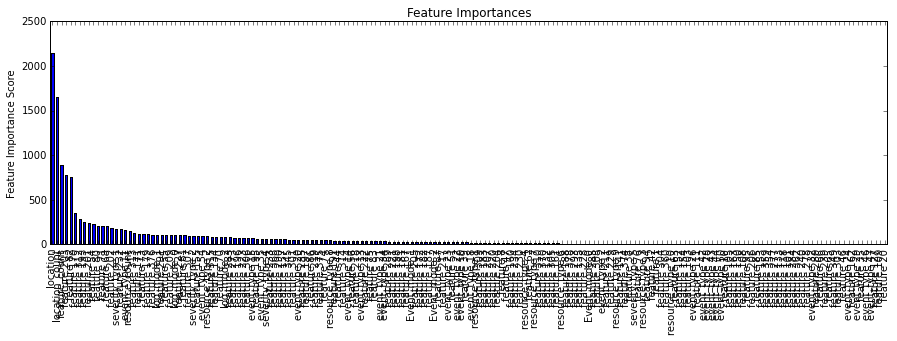

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


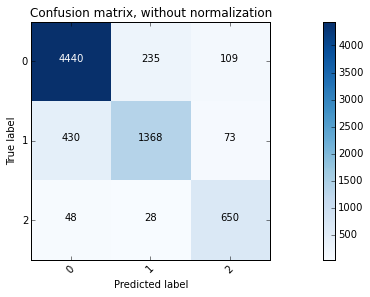

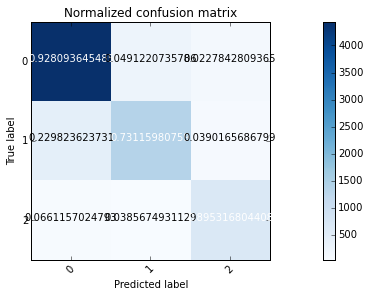

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=1, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=133, nthread=4,
       objective='multi:softprob', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.95)


In [480]:
xgb3 = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=7, max_delta_step=1,
                     min_child_weight=1,
                     gamma=0.1, subsample=0.95, colsample_bytree=0.6,
                     reg_alpha=0.05, objective='multi:softprob',
                     nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb3, train, predictors)

[0]	train-mlogloss:1.09239	test-mlogloss:1.09272
[1]	train-mlogloss:1.08608	test-mlogloss:1.08673
[2]	train-mlogloss:1.07975	test-mlogloss:1.08074
[3]	train-mlogloss:1.0733	test-mlogloss:1.07467
[4]	train-mlogloss:1.06711	test-mlogloss:1.06883
[5]	train-mlogloss:1.06103	test-mlogloss:1.06311
[6]	train-mlogloss:1.05513	test-mlogloss:1.05756
[7]	train-mlogloss:1.04926	test-mlogloss:1.05209
[8]	train-mlogloss:1.04319	test-mlogloss:1.04636
[9]	train-mlogloss:1.03733	test-mlogloss:1.04091
[10]	train-mlogloss:1.03145	test-mlogloss:1.03537
[11]	train-mlogloss:1.02571	test-mlogloss:1.03
[12]	train-mlogloss:1.02003	test-mlogloss:1.02467
[13]	train-mlogloss:1.01439	test-mlogloss:1.01936
[14]	train-mlogloss:1.00887	test-mlogloss:1.01422
[15]	train-mlogloss:1.0033	test-mlogloss:1.00898
[16]	train-mlogloss:0.99792	test-mlogloss:1.0039
[17]	train-mlogloss:0.992567	test-mlogloss:0.998919
[18]	train-mlogloss:0.987347	test-mlogloss:0.99405
[19]	train-mlogloss:0.982119	test-mlogloss:0.989203
[20]	train-

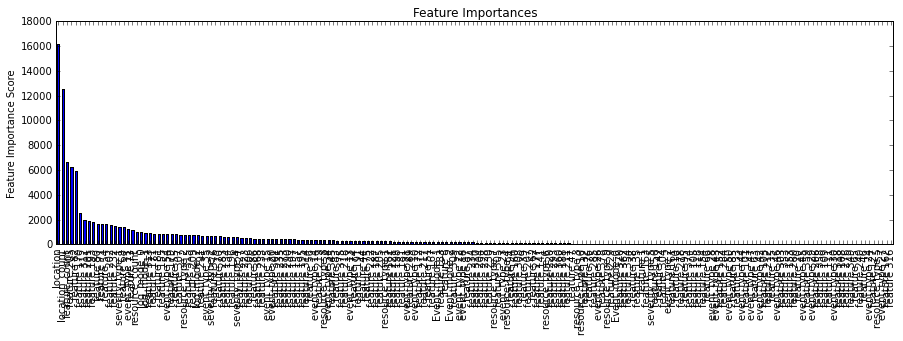

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


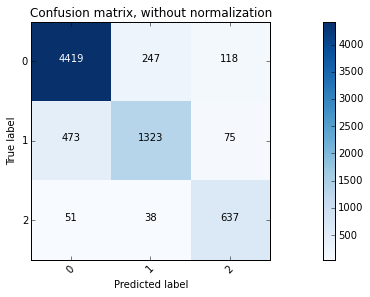

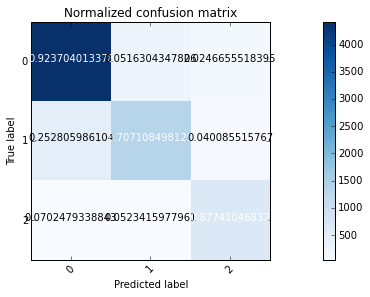

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.4, learning_rate=0.01, max_delta_step=1, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1162, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.95)


In [481]:
xgb4 = XGBClassifier(learning_rate=0.01, n_estimators=5000, max_depth=7,max_delta_step=1,
                     min_child_weight=1,
                     gamma=0.4, subsample=0.95, colsample_bytree=0.6, 
                     reg_alpha=0, objective='multi:softprob', nthread=4,
                     scale_pos_weight=1, seed=27)
modelfit(xgb4, train, predictors)

## Apparently we hit our best performance on the first set of parameters we set.

In [490]:
xgbs = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
                     gamma=0, learning_rate=0.1, max_delta_step=1, max_depth=10,
                     min_child_weight=1, missing=None, n_estimators=80, nthread=4,
                     objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                     scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [491]:
xgbs.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=1, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=80, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

xgb4.fit(TrainingData[list(d_vector.keys())],y)

In [492]:
sc = xgbs.predict(X)

In [493]:
sc

array([ 1.,  0.,  1., ...,  1.,  0.,  0.])

In [494]:
np.array(y)

array([ 1.,  0.,  1., ...,  1.,  0.,  0.])

In [495]:
xgbs.score(X, y)

0.9314456035767511

In [496]:
TestingData.head()

,id,location,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,event_type 21,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,2,474,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,3,64,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,4,645,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,7,638,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,9,1100,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [497]:
TrainingData.head()

,id,location,fault_severity,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,...,resource_type 2,resource_type 1,resource_type 8,resource_type 3,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count
0,1,601,1.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,5,460,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,6,332,1.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,8,243,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,13,418,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [498]:
y_toSave = xgb2.predict(TestingData.drop(['id'],1))

In [499]:
y_toSave

array([ 0.,  1.,  0., ...,  0.,  0.,  0.])

In [500]:
ToSave = TestingData
ToSave['fault_severity'] = y_toSave

In [501]:
def Fault0(row):
    if row['fault_severity'] == 0:
        return 1
    else:
        return 0
    
def Fault1(row):
    if row['fault_severity'] == 1:
        return 1
    else:
        return 0    
    
def Fault2(row):
    if row['fault_severity'] == 2:
        return 1
    else:
        return 0   

In [502]:
ToSave['predict_0'] = ToSave.apply(lambda x: Fault0(x), 1)
ToSave['predict_1'] = ToSave.apply(lambda x: Fault1(x), 1)
ToSave['predict_2'] = ToSave.apply(lambda x: Fault2(x), 1)

In [503]:
ToSave.head()

,id,location,event_type 43,event_type 22,event_type 24,event_type 47,event_type 54,event_type 18,event_type 28,event_type 21,...,resource_type 5,resource_type 4,resource_type 10,resource_type 9,resource_type 7,resource_count,fault_severity,predict_0,predict_1,predict_2
0,2,474,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,1,0,0
1,3,64,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,0,1,0
2,4,645,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0.0,1,0,0
3,7,638,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,1,0,0
4,9,1100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,0,1,0


In [362]:
ToSave = ToSave[['id', 'predict_0', 'predict_1', 'predict_2']]

In [363]:
ToSave.to_csv('results.csv', index=False)